2/25/25

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

rng = np.random.default_rng()

If we know that there are a mix of Type Ias and Ibcs, can we use that to constrain the mixing fraction and parameter estimates?

If we have data about two parameters and we know they both come from two different populations, we want to constrain the mixing fraction $\alpha$ as well as the means and stdevs of all 4 distributions (2 parameters from 2 populations).

In [12]:
num_samples = 1000

def get_samples(alpha, mu_a, mu_b, sigma_a, sigma_b, num_samples = 1000):
    samples = np.zeros(num_samples)

    for i in range(num_samples):
        sample_alpha = rng.random()
        if sample_alpha < alpha:
            samples[i] = rng.normal(mu_a, sigma_a)
        else:
            samples[i] = rng.normal(mu_b, sigma_b)
    return samples

Now we generate fake data for the two parameters.

In [20]:
alpha = 0.4

param_a_samples = get_samples(alpha, 1, 2, 0.2, 0.4)
param_b_samples = get_samples(alpha, 2, 5, 0.3, 2)

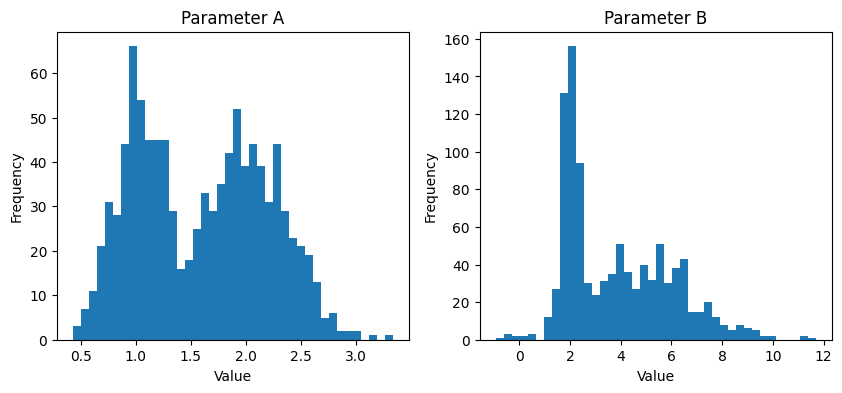

In [256]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(param_a_samples, bins=40)
ax[0].set_title("Parameter A")
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Frequency")


ax[1].hist(param_b_samples, bins=40)
ax[1].set_title("Parameter B")
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Frequency")

plt.show()

Shoutout https://www.geeksforgeeks.org/ml-expectation-maximization-algorithm/

In [41]:
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

It's a bit sensitive to initialization....

In [237]:
num_epochs = 50
lls = []

mu_a1, mu_b1, mu_a2, mu_b2 = 1, 1, 3, 3
sigma_a1, sigma_b1, sigma_a2, sigma_b2 = 0.5, 0.5, 0.5, 0.5
alpha = 0.1

for epoch in range(num_epochs):
    # the gammas are weights for every sample
    gamma_a1 = alpha * norm.pdf(param_a_samples, mu_a1, sigma_a1)
    gamma_a2 = (1 - alpha) * norm.pdf(param_a_samples, mu_a2, sigma_a2)

    gamma_b1 = alpha * norm.pdf(param_b_samples, mu_b1, sigma_b1)
    gamma_b2 = (1 - alpha) * norm.pdf(param_b_samples, mu_b2, sigma_b2)
    
    # Normalize over parameter
    gamma_a_total = (gamma_a1 + gamma_a2)
    gamma_b_total = (gamma_b1 + gamma_b2)
    gamma_a1 /= gamma_a_total
    gamma_a2 /= gamma_a_total
    gamma_b1 /= gamma_b_total
    gamma_b2 /= gamma_b_total
    
    # update parameters according to these weights
    mu_a1 = np.sum(gamma_a1 * param_a_samples) / np.sum(gamma_a1)
    mu_a2 = np.sum(gamma_a2 * param_a_samples) / np.sum(gamma_a2)
    mu_b1 = np.sum(gamma_b1 * param_b_samples) / np.sum(gamma_b1)
    mu_b2 = np.sum(gamma_b2 * param_b_samples) / np.sum(gamma_b2)
    sigma_a1 = np.sqrt(np.sum(gamma_a1 * (param_a_samples - mu_a1)**2) / np.sum(gamma_a1))
    sigma_a2 = np.sqrt(np.sum(gamma_a2 * (param_a_samples - mu_a2)**2) / np.sum(gamma_a2))
    sigma_b1 = np.sqrt(np.sum(gamma_b1 * (param_b_samples - mu_b1)**2) / np.sum(gamma_b1))
    sigma_b2 = np.sqrt(np.sum(gamma_b2 * (param_b_samples - mu_b2)**2) / np.sum(gamma_b2))
    
    # Here we can use information from both parameters to constrain the mixing fraction
    alpha = np.mean(np.concatenate((gamma_a1, gamma_b1)))
    # alpha = np.mean(gamma_a1)
    
    ll_a = log_likelihood([mu_a1, sigma_a1, mu_a2, sigma_a2], param_a_samples, alpha)
    ll_b = log_likelihood([mu_b1, sigma_b1, mu_b2, sigma_b2], param_b_samples, alpha)

    lls.append(ll_a + ll_b)
    

In [238]:
mu_a1, sigma_a1, mu_a2, sigma_a2, mu_b1, sigma_b1, mu_b2, sigma_b2, alpha

(1.0058314201953102,
 0.21273177588699071,
 2.00417446694161,
 0.3872119811944152,
 2.009630211818413,
 0.296843246988857,
 4.944703975338221,
 1.9486656824441417,
 0.392525522779575)

Text(0, 0.5, 'Log-likelihood')

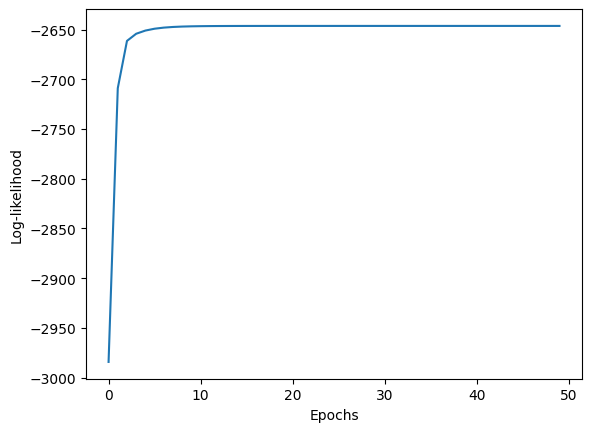

In [239]:
plt.plot(np.arange(num_epochs), lls)
plt.xlabel("Epochs")
plt.ylabel("Log-likelihood")

In [240]:
def plot_mixture(params, alpha, ax, xlims=[0,5]):
    x = np.linspace(*xlims, 500)
    mu1, sigma1, mu2, sigma2 = params
    ax.plot(x, stats.norm.pdf(x, mu1, sigma1), label="Dist 1", color='r')
    ax.plot(x, stats.norm.pdf(x, mu2, sigma2), label="Dist 2", color='b')
    ax.set_ylim(0,2)
    ax.legend()

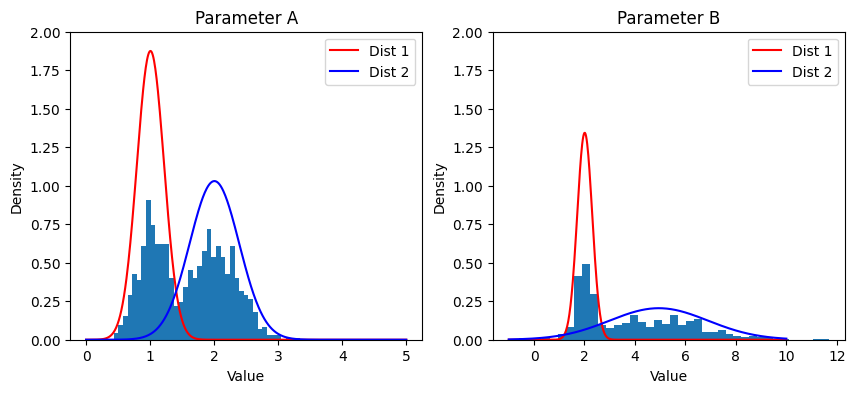

In [259]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(param_a_samples, bins=40, density=True)
plot_mixture([mu_a1, sigma_a1, mu_a2, sigma_a2], alpha, ax=ax[0])
ax[0].set_title("Parameter A")
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Density")
ax[1].hist(param_b_samples, bins=40, density=True)
plot_mixture([mu_b1, sigma_b1, mu_b2, sigma_b2], alpha, ax=ax[1], xlims=[-1,10])
ax[1].set_title("Parameter B")
ax[1].set_xlabel("Value")
ax[1].set_ylabel("Density")
plt.show()